# Problem

Here is the [dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/00422/). The data set contains wifi signal strength observed from 7 wifi devices on a smartphone collected in indoor space. Predict location from wifi signal strength. Also report Accuracy, Confusion Matrix and F1 Score



### Loading all modules

In [1]:
import pandas as pd
import numpy as np

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, plot_confusion_matrix
from itertools import cycle

import graphviz
import matplotlib.pyplot as plt

print_divider = "*"* 100

### Decision Tree Classifier

In [2]:
def sklearn_dt_classifier(X_train, y_train, crit='entropy'):
    '''
    X_train: Input features 
    y_train: Class label for the training data(X_train)
    criterion: default is "entropy", it could be "gini" as well

    returns:
    clf_tree: df_classifier object 
    '''
    clf_tree = DecisionTreeClassifier(criterion=crit)
    clf_tree.fit(X_train, y_train)

    return clf_tree

### ROC AUC Curve Generator

In [3]:
def roc_curve_generator(Y, y_test, y_pred, image_name):

    # Total no. of unique class 
    n_classes = len(Y.unique())

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    roc_for_algo = dict() 

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(y_test))[:, i], np.array(pd.get_dummies(y_pred))[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Final averaging it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot the ROC curves
    line_width=3
    plt.figure(figsize=(10,10))
    plt.plot(fpr["macro"], tpr["macro"],
            label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["macro"]),
            color='green', linestyle=':', lw=line_width)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=line_width,
                label='ROC curve of class {0} (area = {1:0.2f})'
                ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--',color='green', lw=line_width)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate(FPR)')
    plt.ylabel('True Positive Rate(TPR)')
    plt.title('ROC for the Decision Tree')
    plt.legend(loc="lower right")

    # Uncomment it when using in .py
    #plt.savefig(image_name)
    
    # Comment this when using in .py
    plt.show()

    roc_for_algo["roc_auc"] = roc_auc
    roc_for_algo["tpr"] = tpr
    roc_for_algo["fpr"] = fpr

    return roc_for_algo

### Model Evaluation

In [4]:
def model_evaluation(y_test, y_pred):
    # Accuracy 
    accuracy = accuracy_score(y_test, y_pred)

    # Confusion Matrix 
    cm = confusion_matrix(y_test, y_pred)

    print(print_divider)
    # Precision and Recall (Classification Report) 
    clf_report = classification_report(y_test, y_pred)
    print("Classification Report")
    print(clf_report)
    print(print_divider)

    # Sensitivity and Specificity
    mcm = multilabel_confusion_matrix(y_test, y_pred)
    tn = mcm[:, 0, 0]
    tp = mcm[:, 1, 1]
    fn = mcm[:, 1, 0]
    fp = mcm[:, 0, 1]
    sensitivity = tp / (tp + fn) 
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)

    print(f"Accuracy : {accuracy}")
    print(print_divider)
    print(f"Confusion Matrix : \n {cm}")
    print(print_divider)
    for c in range(len(precision)):
        print(f"Precision for class {c} : {precision[c]}")
    print(print_divider)
    for c in range(len(sensitivity)):
        print(f"Sensitivity for class {c} : {sensitivity[c]}")
    print(print_divider)
    for c in range(len(specificity)):
        print(f"Specificity for class {c} : {specificity[c]}")
    print(print_divider)

### Visualize the Decision Tree

In [5]:
def dt_graph(clf_tree, data_df):

    dot_data = tree.export_graphviz(clf_tree, out_file=None, 
                        feature_names=data_df.columns[:-1],  
                        class_names=data_df.columns[-1],  
                        filled=True, rounded=True,  
                        special_characters=True)  
    graph = graphviz.Source(dot_data)  
    graph.render(filename='DT_Graph')
    f_name = 'DT_Graph.pdf'
    print(f"Visual Graph of the Decision Tree is saved at the present working directory with file name : {f_name}")
    

### Main Function Starts from here

#### 1. Loading the dataset

In [6]:
input_file = "wifi_localization.txt"
df = pd.read_csv(input_file, delimiter="\t", header=None)
df = df.sample(frac=1).reset_index(drop=True)
df.columns = ["x1", "x2", "x3", "x4", "x5", "x6", "x7", "class_label"]

# Create X (Input features)
X = df.drop("class_label", axis=1)
# Create y (Target label)
Y = df["class_label"]

#### 2. Spliting the dataset

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.20)

In [8]:
X_train.head()

,x1,x2,x3,x4,x5,x6,x7
122,-10,-58,-62,-20,-73,-76,-74
536,-48,-60,-57,-52,-61,-85,-84
1916,-50,-49,-54,-48,-62,-79,-75
30,-59,-52,-58,-65,-66,-82,-80
88,-17,-74,-60,-15,-73,-71,-80


In [9]:
y_train.head()

122     2
536     3
1916    3
30      1
88      2
Name: class_label, dtype: int64

In [10]:
X_test.head()

,x1,x2,x3,x4,x5,x6,x7
15,-50,-55,-51,-57,-58,-86,-86
1456,-46,-46,-52,-52,-57,-77,-82
524,-68,-58,-65,-67,-83,-89,-86
485,-52,-56,-51,-46,-63,-86,-82
926,-56,-55,-44,-61,-51,-84,-87


In [11]:
X_train.shape

(1600, 7)

In [12]:
X_test.shape

(400, 7)

#### 3. Decision Tree Classifier 

In [13]:
clf_tree = sklearn_dt_classifier(X_train, y_train, crit='entropy')

In [14]:
clf_tree

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

#### 4. Predecting the Result 

In [15]:
y_pred = clf_tree.predict(X_test)

#### 5. Evaluating the Performance 

In [16]:
print("Model Evaluation for 'SCI-KIT LEARN DECISION TREE CLASSIFIER'")
model_evaluation(y_test, y_pred)

Model Evaluation for 'SCI-KIT LEARN DECISION TREE CLASSIFIER'
****************************************************************************************************
Classification Report
              precision    recall  f1-score   support

           1       1.00      0.98      0.99       100
           2       0.98      0.94      0.96       114
           3       0.91      0.97      0.94        89
           4       0.98      1.00      0.99        97

    accuracy                           0.97       400
   macro avg       0.97      0.97      0.97       400
weighted avg       0.97      0.97      0.97       400

****************************************************************************************************
Accuracy : 0.97
****************************************************************************************************
Confusion Matrix : 
 [[ 98   0   1   1]
 [  0 107   7   0]
 [  0   2  86   1]
 [  0   0   0  97]]
****************************************************************

#### 6. ROC Curve for Decision Tree 

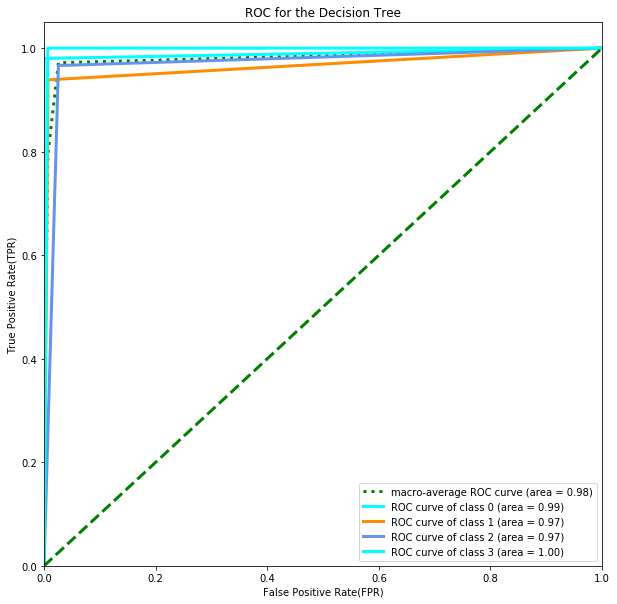

In [17]:
roc_for_dt = roc_curve_generator(Y=Y, y_test=y_test, y_pred=y_pred, image_name="ROC_CURVE_SKLEARN_DT.png")

#### 6. Confusion Matrix

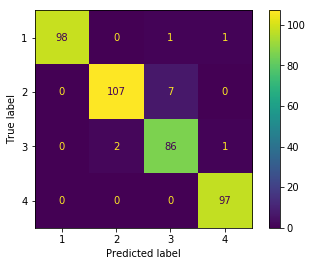

In [18]:
plot_confusion_matrix(clf_tree, X_test, y_test, values_format='d')

#### 5. Plot and visualize your Decision Tree


In [19]:
dt_graph(clf_tree, df)

Visual Graph of the Decision Tree is saved at the present working directory with file name : DT_Graph.pdf
